In [1]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import files
!cp /content/drive/Shareddrives/ML_PROJET2/Project_2/helpers.py /content
!cp /content/drive/Shareddrives/ML_PROJET2/Project_2/utils.py /content
!cp /content/drive/Shareddrives/ML_PROJET2/Project_2/models.py /content
!cp /content/drive/Shareddrives/ML_PROJET2/Project_2/helpers_mya.py /content

Mounted at /content/drive


In [2]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.4 MB/s eta 0:00:00


In [3]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

from utils import *
from helpers import *
from models import *
import helpers_mya

In [4]:
# Loaded a set of images
root_dir = "/content/drive/Shareddrives/ML_PROJET2/Project_2/data/training/"
image_dir = root_dir + "images/"
gt_dir = root_dir + "groundtruth/"

imgs = extract_data_for_unet(image_dir, 100)
gt_imgs = extract_labels_for_unet(gt_dir, 100)

Loaded 100 images.
Loaded 100 groundtruth images.
Shape of GT images :  (100, 400, 400)


In [90]:
import cv2
from PIL import Image
import os
import matplotlib.image as mpimg

def load_images_from_folder(folder, num_images=100, is_gray=False):
    images = []
    for i in range(1, num_images + 1):
      imageid = "satImage_%.3d" % i
      imageid = imageid + ".png"
      img_path = os.path.join(folder, imageid)
      if is_gray:
        img = mpimg.imread(img_path, cv2.IMREAD_GRAYSCALE)
      else:
        img = mpimg.imread(img_path)

      if img is not None:
        images.append(img)
    print(len(images))
    return images

def create_folder_if_not_exists(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

def translate_image(image, x, y):
    rows, cols = image.shape[:2]
    translation_matrix = np.float32([[1, 0, x], [0, 1, y]])
    translated_image = cv2.warpAffine(image, translation_matrix, (cols, rows))
    return translated_image

def augment_images_no_save(satellite_images, groundtruth_images):
    if len(satellite_images) != len(groundtruth_images):
        raise ValueError("The number of satellite images and groundtruth images must be the same")
    imgs = []
    gt_imgs = []

    angles = [45,90,135, 180, 225,270, 315]  # List of angles for rotations
    translations = [(120, 120), (-120, -120)]  # Translations (right-down and left-up)
    zoom_factors = [1.25, 1.35] # List of zooms

    for i in range(1, len(satellite_images) + 1):
        satellite_img = satellite_images[i - 1]
        groundtruth_img = groundtruth_images[i - 1]

        # Rotate and save
        for angle in angles:
            M = cv2.getRotationMatrix2D((satellite_img.shape[1] / 2, satellite_img.shape[0] / 2), angle, 1)
            M_gt = cv2.getRotationMatrix2D((groundtruth_img.shape[1] / 2, groundtruth_img.shape[0] / 2), angle, 1)
            rotated_satellite = cv2.warpAffine(satellite_img, M, (satellite_img.shape[1], satellite_img.shape[0]))
            rotated_groundtruth = cv2.warpAffine(groundtruth_img, M_gt, (groundtruth_img.shape[1], groundtruth_img.shape[0]),flags=cv2.INTER_NEAREST)

            imgs.append(rotated_satellite)
            gt_imgs.append(rotated_groundtruth)

        # Flip and save
        flipped_satellite = cv2.flip(satellite_img, 1)  # Horizontal flip
        flipped_groundtruth = cv2.flip(groundtruth_img, 1)

        imgs.append(flipped_satellite)
        gt_imgs.append(flipped_groundtruth)

        # Translate and save
        for x, y in translations:
            translated_satellite = translate_image(satellite_img, x, y)
            #translated_groundtruth = translate_image(groundtruth_img, x, y)

            translation_matrix_gt = np.float32([[1, 0, x], [0, 1, y]])
            translated_groundtruth = cv2.warpAffine(groundtruth_img, translation_matrix_gt, (groundtruth_img.shape[1], groundtruth_img.shape[0]), flags=cv2.INTER_NEAREST)

            imgs.append(translated_satellite)
            gt_imgs.append(translated_groundtruth)

        for factor in zoom_factors:
            # Zoom
            zoomed_satellite = zoom_image(satellite_img, factor)
            zoomed_groundtruth = zoom_image(groundtruth_img, factor)

            imgs.append(zoomed_satellite)
            gt_imgs.append(zoomed_groundtruth)

    return np.asarray(imgs), np.asarray(gt_imgs)

def zoom_image(image, factor):
    """
    Zooms in or out on an image.

    Args:
        image (np.array): The image to be zoomed.
        factor (float): The zoom factor. Values < 1 will zoom out, values > 1 will zoom in.

    Returns:
        np.array: The zoomed image.
    """
    if factor <= 1:
        return image  # No zoom if factor is 1 or less

    height, width = image.shape[:2]
    new_height, new_width = int(height / factor), int(width / factor)
    startx = width // 2 - (new_width // 2)
    starty = height // 2 - (new_height // 2)
    cropped_image = image[starty:starty + new_height, startx:startx + new_width]
    zoomed_image = cv2.resize(cropped_image, (width, height), interpolation=cv2.INTER_LINEAR)
    return zoomed_image

def v(gts):
  foreground_threshold = 0.25

  # Initialize labels array
  labels = np.zeros((gts.shape[0], gts.shape[1], gts.shape[2], 2), dtype=np.float32)

  # Apply threshold to create a boolean mask for foreground
  foreground_mask = gts > foreground_threshold

  # Use the mask to assign [0, 1] to foreground and [1, 0] to background
  labels[..., 0] = 1 - foreground_mask  # Background
  labels[..., 1] = foreground_mask      # Foreground

  return labels





In [91]:
satellite_images = load_images_from_folder('/content/drive/Shareddrives/ML_PROJET2/Project_2/data/training/images')
groundtruth_images = load_images_from_folder('/content/drive/Shareddrives/ML_PROJET2/Project_2/data/training/groundtruth', is_gray=True)

print(len(satellite_images))

# Perform augmentation
aug_imgs, aug_gts = augment_images_no_save(satellite_images, groundtruth_images)

100
100
100


In [92]:
aug_gts = v(aug_gts)
print(aug_gts.shape)

(1400, 400, 400, 2)


In [95]:
x = 12
gt = np.argmax(aug_gts[x], 2)

img = make_img_overlay(aug_imgs[x], gt)

/content/helpers.py:260: RuntimeWarning: invalid value encountered in divide
  rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)


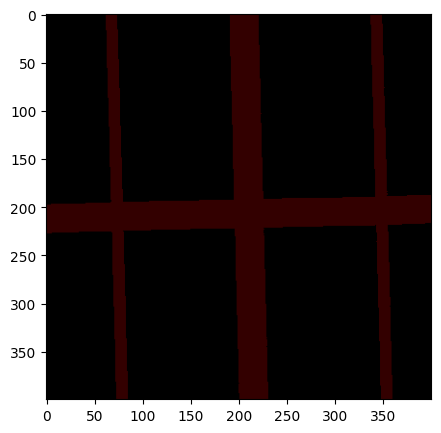

In [96]:
fig = plt.figure(figsize=(5,5))
plt.imshow(img)

In [39]:
no_gt = np.argmax(gt_imgs[0], 2)

no_img = make_img_overlay(imgs[0], no_gt)

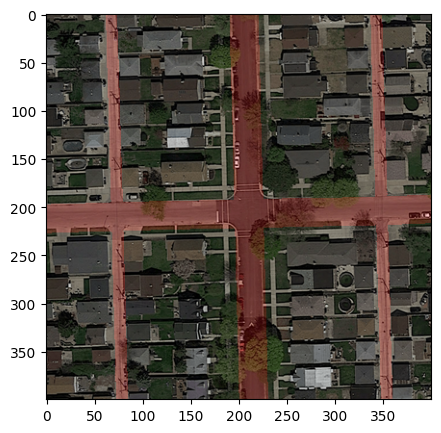

In [40]:
fig1 = plt.figure(figsize=(5,5))
plt.imshow(no_img)

In [97]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 12.5 MB/s eta 0:00:00


In [102]:
model64RD = build_unet(input_shape=(400, 400, 3), start_filter=64, num_stages= 4,dropout = 0.1, activation='relu', regularization=1e-8)

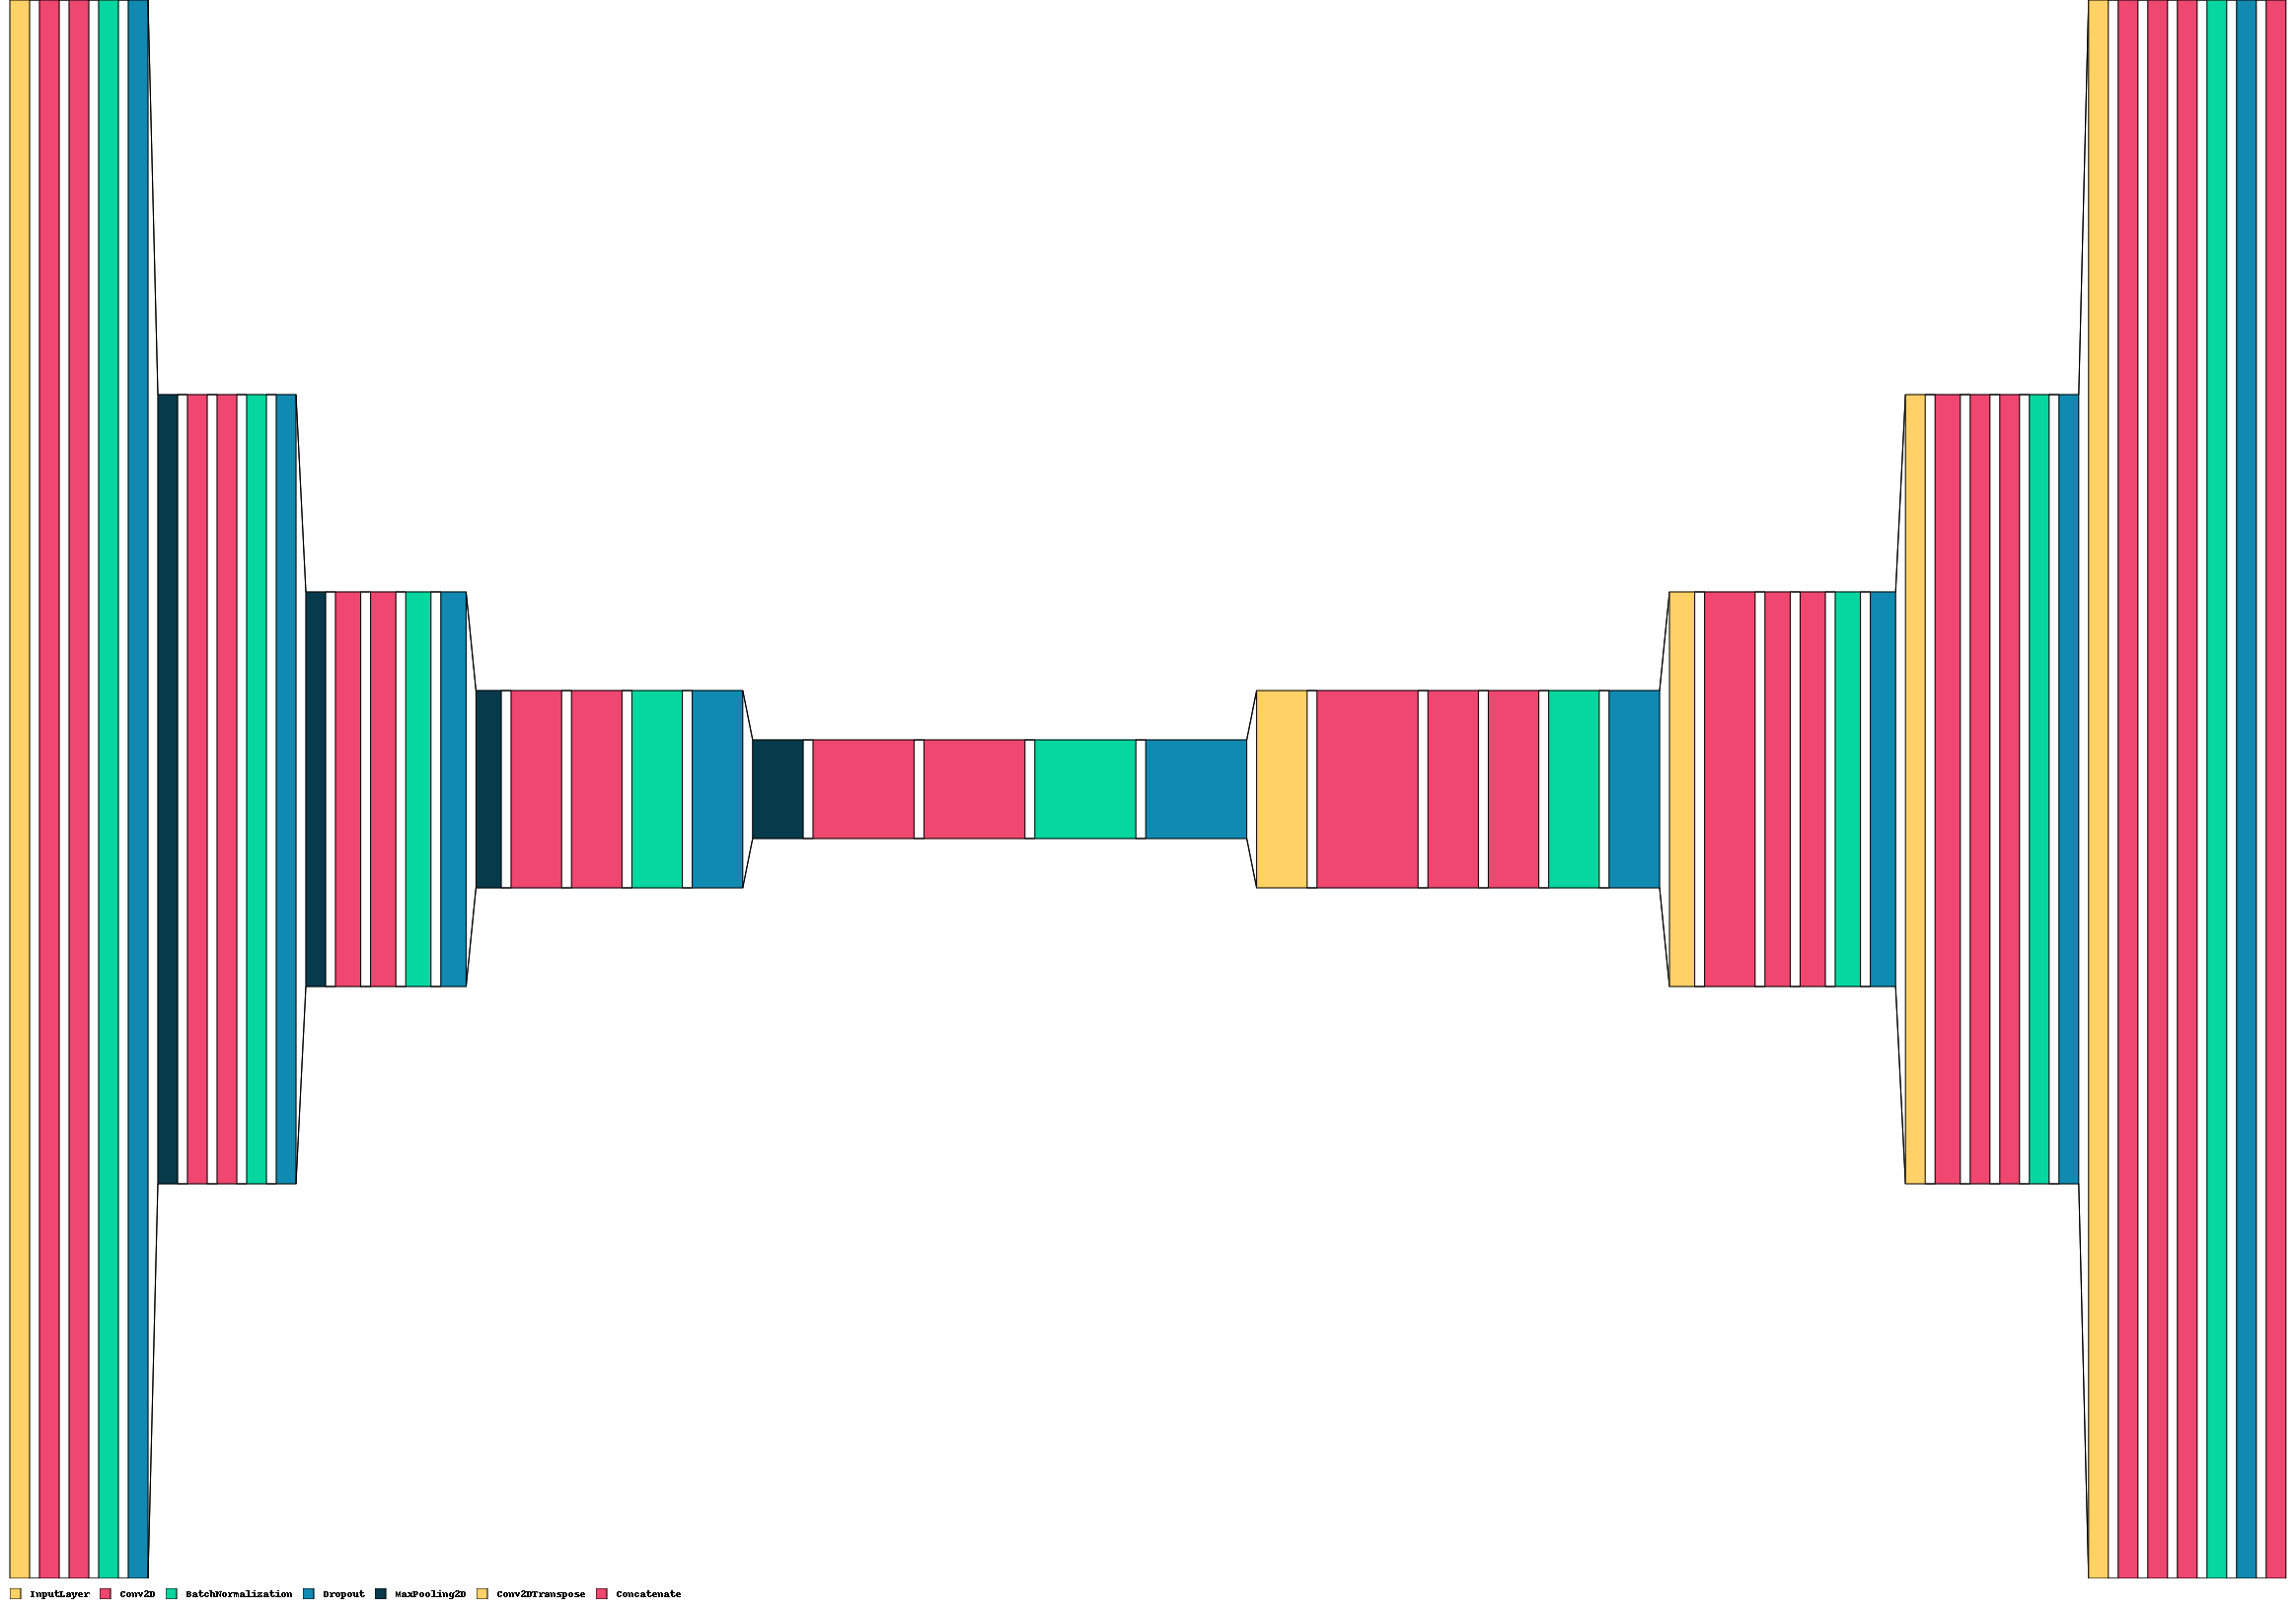

In [106]:
import visualkeras



visualkeras.layered_view(model64RD, legend=True,draw_volume=False, to_file='/content/drive/Shareddrives/ML_PROJET2/Project_2/model64RD.png')